In [1]:
import os

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [3]:
import matplotlib.pyplot as plt

# <span style = 'color : Navy; '> Obejctives

> Build Synthetic Arithmatic Brownian Motion using `Python`,`CPP`,`Rust`

$$
dX_{t} = \mu dt + \sigma dW_{t}
$$

$$
X_{t} = X_{0} + \mu t + \sigma W_{t}
$$

$$
X_{t} = X_{0} + \mu \sum_{k=0}^{n-1}  \Delta t + \sigma \sum_{k=0}^{n-1} \sqrt{\Delta t}\,\large \varepsilon_k
$$

> `python`

In [4]:
def discrete_bm_stock(
    x0 = 100,
    mu = 5,
    sigma = 3,
    T = 1,
    N = 252
):
    dt = T / N
    eps = np.random.normal(0,1,N)
    X = np.zeros(N+1)
    X[0] = x0

    for t in range(N):
        X[t+1] = X[t] + mu*dt + sigma*np.sqrt(dt)*eps[t]
    
    return X

In [5]:
data_ls = []
for _ in range(10):
    for mu in np.random.randint(2,10,1):
        for sigma in np.random.randint(5,10,1):
            data_ls.append(discrete_bm_stock(mu = mu, sigma = sigma))

<Axes: >

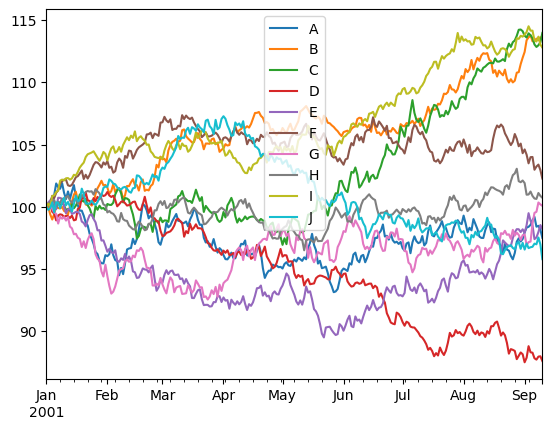

In [6]:
data_df=\
(
    pd
    .DataFrame(
        data = np.asarray(data_ls).T,
        columns = list('ABCDEFGHIJ'),
        index = [ datetime(2001,1,1) + relativedelta(days =i) for i in range(253)]
    )
)
data_df.plot()

> `CPP`

In [7]:
%%writefile discrete_bsm1.cpp

#include <vector>
#include <random>
#include <cmath>
#include <iostream>

std::vector<double> discrete_bm_stock(
    double x0 = 100.0,
    double mu = 5.0,
    double sigma = 3.0,
    double T = 1.0,
    int N = 252
) {
    double dt = T / N;

    std::random_device rd;
    std::mt19937 gen(rd());
    std::normal_distribution<> dist(0.0, 1.0);

    std::vector<double> X(N + 1);
    X[0] = x0;

    for (int t = 0; t < N; ++t) {
        double eps = dist(gen);
        X[t + 1] = X[t]
                 + mu * dt
                 + sigma * std::sqrt(dt) * eps;
    }

    return X;
}

int main(){
    auto path = discrete_bm_stock(100.0, 1.0, 5.0, 1.0, 252);

    for (int i = 0; i < 252; ++i) {
        std::cout << path[i] << "\n";
    }
    return 0;
}


Overwriting discrete_bsm1.cpp


In [8]:
!g++ -std=c++17 discrete_bsm1.cpp -o discrete_bsm1
!./discrete_bsm1 > bm.txt  

In [9]:
data = np.loadtxt("bm.txt")
data.shape

(252,)

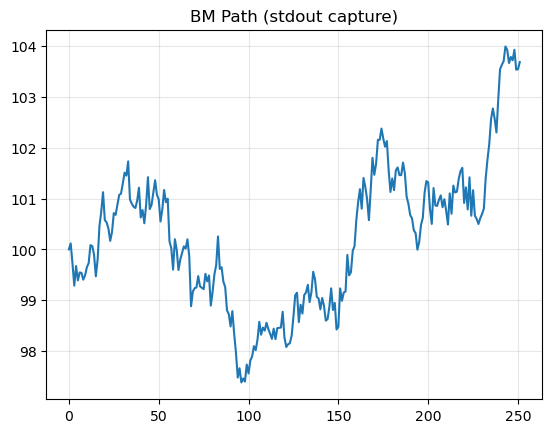

In [10]:
plt.plot(data)
plt.title("BM Path (stdout capture)")
plt.grid(alpha=0.3)
plt.show()

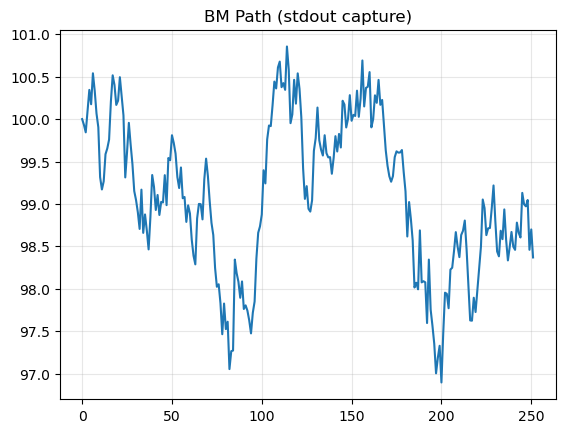

In [11]:
!g++ -std=c++17 discrete_bsm1.cpp -o discrete_bsm1
!./discrete_bsm1 > bm2.txt
data2 = np.loadtxt('bm2.txt')
plt.plot(data2)
plt.title("BM Path (stdout capture)")
plt.grid(alpha=0.3)
plt.show()

In [24]:
%%writefile discrete_bsm2.cpp
#include <vector>
#include <iostream>
#include <random>
#include <cmath>
#include <fstream>
#include <cstdint>

std::vector<double> discrete_bm_stock(
    double x0 = 100,
    double mu = 10.0,
    double sigma = 3.0,
    double T = 1,
    int N = 252
){
    double dt = T/N;
    std::random_device rd;
    std::mt19937 gen(rd());
    std::normal_distribution<> dist(0.0, 1.0);

    std::vector<double> X(N+1);
    X[0] = x0;

    for (int t=0; t < N; ++t){
        double epsillon = dist(gen);
        X[t+1] = X[t] 
                 + mu * dt 
                 + sigma * std::sqrt(dt) * epsillon;
    }
    return X;
}


int main() {

    std::ofstream file("bm_all.csv");
    file << "path_id,t,price\n";

    for (std::int64_t i = 0; i < 1000LL; ++i) {

        auto path = discrete_bm_stock(
            100.0,   // x0
            1.0,     // mu
            5.0,     // sigma
            100.0,   // T = 100 years
            252*100  // N
        );

        for (int t = 0; t < path.size(); ++t) {
            file << i << "," << t << "," << path[t] << "\n";
        }
    }

    file.close();

    std::cout << "bm_all.csv written successfully\n";
    return 0;
}

Overwriting discrete_bsm2.cpp


In [25]:
!g++ -std=c++17 discrete_bsm2.cpp -o discrete_bsm2
!./discrete_bsm2

bm_all.csv written successfully


In [26]:
df= pd.read_csv("bm_all.csv")
df.head()

,path_id,t,price
0,0,0,100.000
1,0,1,100.123
2,0,2,100.208
3,0,3,100.699
4,0,4,100.294


> `rust`

In [12]:
!mkdir -p rust_bm/src

In [13]:
%%writefile rust_bm/Cargo.toml
[package]
name = "rust_bm"
version = "0.1.0"
edition = "2021"

[dependencies]
rand = "0.8"
rand_distr = "0.4"

Overwriting rust_bm/Cargo.toml


In [14]:
%%writefile rust_bm/src/main.rs
use std::fs::File;
use std::io::{BufWriter, Write};

use rand::prelude::*;
use rand_distr::{Distribution, Normal};

fn discrete_bm_stock(
    x0: f64,
    mu: f64,
    sigma: f64,
    t: f64,
    n: usize,
    rng: &mut ThreadRng,
    normal: &Normal<f64>,
) -> Vec<f64> {
    let dt = t / n as f64;
    let sqrt_dt = dt.sqrt();

    let mut x = Vec::with_capacity(n + 1);
    x.push(x0);

    let mut current_price = x0;

    for _ in 0..n {
        let epsilon: f64 = normal.sample(rng);
        current_price += mu * dt + sigma * sqrt_dt * epsilon;
        x.push(current_price);
    }
    x
}

fn main() {
    println!("Simulation");

    let file = File::create("bm_all2.csv").expect("Unable to create file");
    let mut writer = BufWriter::new(file);

    writeln!(writer, "path_id,t,price").expect("Unable to write header");

    let num_paths: usize = 1000;
    let n_steps: usize = 252 * 100;

    let mut rng = thread_rng();
    let normal = Normal::new(0.0, 1.0).unwrap();

    for i in 0..num_paths {
        let path = discrete_bm_stock(100.0, 1.0, 5.0, 100.0, n_steps, &mut rng, &normal);

        for (t, price) in path.iter().enumerate() {
            writeln!(writer, "{},{},{:.6}", i, t, price).expect("Write error");
        }
    }

    writer.flush().expect("Flush error");
    println!("bm_all2.csv written successfully!");
}


Overwriting rust_bm/src/main.rs


In [ ]:
!cd rust_bm && cargo run --release

   Compiling rust_bm v0.1.0 (/Users/frankyoh979/rust_bm)
    Building [========================>  ] 20/21: rust_bm(bin)                

In [ ]:
df2 = pd.read_csv("bm_all2.csv")
print(df2.head())
print("rows:", len(df))